   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 30.5 MB/s eta 0:00:00
🔼 Sube tu archivo DXF (por ejemplo: figura_prueba.dxf)


Saving logo1.DXF to logo1.DXF
✅ Archivo cargado: logo1.DXF
🔧 Agrupando endpoints con tolerancia = 0.05 mm
🔹 Clusters de endpoints detectados: 4
✅ Total de trayectorias finales: 1


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129513 (\N{JIGSAW PUZZLE PIECE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


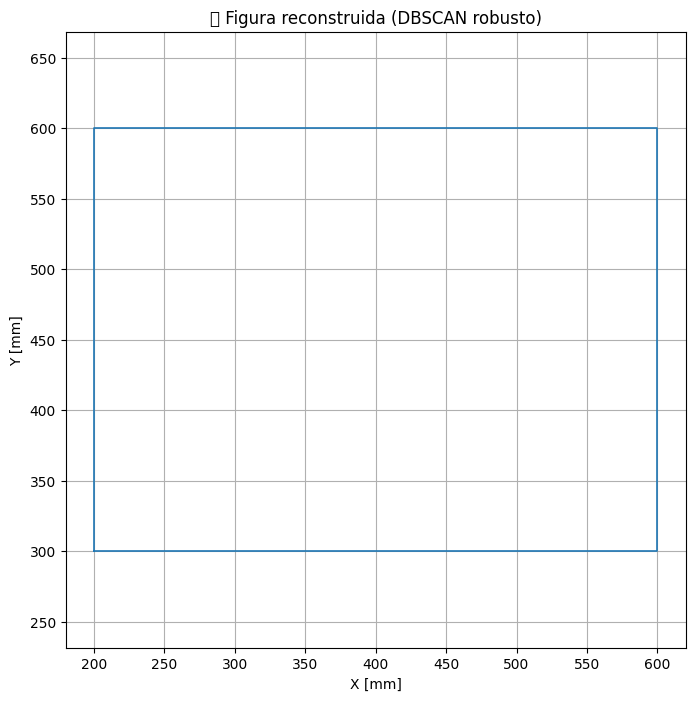

✅ Trayectoria exportada: trayectoria_XY_robusta.txt


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

📤 Descarga lista para MATLAB.


In [ ]:
# =============================================================
# 🦾 CONVERSOR DXF → TXT (robusto, método DBSCAN)
# Harold & Abril · versión final estable
# =============================================================

!pip install ezdxf shapely matplotlib numpy scipy scikit-learn --quiet

import ezdxf
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import LineString, MultiLineString
from shapely.ops import linemerge, unary_union
from scipy.interpolate import splprep, splev
from sklearn.cluster import DBSCAN
from google.colab import files

# -------------------------------------------------------------
# 1️⃣ SUBIR ARCHIVO DXF
# -------------------------------------------------------------
print("🔼 Sube tu archivo DXF (por ejemplo: figura_prueba.dxf)")
uploaded = files.upload()
dxf_file = list(uploaded.keys())[0]
print(f"✅ Archivo cargado: {dxf_file}")

# -------------------------------------------------------------
# 2️⃣ LECTOR DXF UNIVERSAL (solo XY)
# -------------------------------------------------------------
doc = ezdxf.readfile(dxf_file)
msp = doc.modelspace()
geoms = []

def procesar_entidad(e):
    dtype = e.dxftype()
    puntos = []
    try:
        if dtype == "LINE":
            start, end = e.dxf.start, e.dxf.end
            puntos = [[start.x, start.y], [end.x, end.y]]

        elif dtype == "LWPOLYLINE":
            pts = np.array(e.get_points())[:, :2]
            puntos = pts

        elif dtype == "POLYLINE":
            pts = [v.dxf.location[:2] for v in e.vertices]
            puntos = np.array(pts)

        elif dtype == "CIRCLE":
            c, r = e.dxf.center, e.dxf.radius
            t = np.linspace(0, 2*np.pi, 200)
            puntos = np.column_stack([c.x + r*np.cos(t), c.y + r*np.sin(t)])

        elif dtype == "ARC":
            c, r = e.dxf.center, e.dxf.radius
            a1, a2 = np.deg2rad(e.dxf.start_angle), np.deg2rad(e.dxf.end_angle)
            t = np.linspace(a1, a2, 120)
            puntos = np.column_stack([c.x + r*np.cos(t), c.y + r*np.sin(t)])

        elif dtype == "SPLINE":
            fit = np.array(e.fit_points)
            if len(fit) >= 2:
                tck, _ = splprep([fit[:,0], fit[:,1]], s=0)
                u = np.linspace(0, 1, 200)
                x, y = splev(u, tck)
                puntos = np.column_stack([x, y])
            else:
                ctrl = np.array(e.control_points)
                if len(ctrl) >= 2:
                    tck, _ = splprep([ctrl[:,0], ctrl[:,1]], s=0)
                    u = np.linspace(0, 1, 200)
                    x, y = splev(u, tck)
                    puntos = np.column_stack([x, y])

        if len(puntos) > 1:
            geoms.append(LineString(puntos))

    except Exception as ex:
        print(f"⚠️ No se pudo procesar {dtype}: {ex}")

for e in msp:
    procesar_entidad(e)

if not geoms:
    raise ValueError("⚠️ No se detectaron entidades válidas en el DXF.")

# -------------------------------------------------------------
# 3️⃣ AGRUPAR EXTREMOS (DBSCAN)
# -------------------------------------------------------------
tolerancia_endpoints = 0.05  # mm
print(f"🔧 Agrupando endpoints con tolerancia = {tolerancia_endpoints} mm")

endpoints = []
endpoint_map = []
for gi, g in enumerate(geoms):
    coords = list(g.coords)
    endpoints.append(coords[0])
    endpoint_map.append((gi, 0))
    endpoints.append(coords[-1])
    endpoint_map.append((gi, -1))

endpoints = np.array(endpoints)
cl = DBSCAN(eps=tolerancia_endpoints, min_samples=1, metric='euclidean')
labels = cl.fit_predict(endpoints)
n_clusters = labels.max() + 1
print(f"🔹 Clusters de endpoints detectados: {n_clusters}")

# Calcular centroides
centroids = np.zeros((n_clusters, 2))
for k in range(n_clusters):
    pts = endpoints[labels == k]
    centroids[k] = pts.mean(axis=0)

# Reemplazar extremos por centroides
geoms_sanitized = []
for gi, g in enumerate(geoms):
    coords = list(g.coords)
    label_start = labels[2*gi]
    label_end = labels[2*gi + 1]
    new_coords = coords.copy()
    new_coords[0] = tuple(centroids[label_start])
    new_coords[-1] = tuple(centroids[label_end])
    geoms_sanitized.append(LineString(new_coords))

# -------------------------------------------------------------
# 4️⃣ UNIR LÍNEAS CONECTADAS
# -------------------------------------------------------------
union = unary_union(geoms_sanitized)
merged = linemerge(union)

if isinstance(merged, LineString):
    merged = [merged]
elif isinstance(merged, MultiLineString):
    merged = list(merged.geoms)

print(f"✅ Total de trayectorias finales: {len(merged)}")

# -------------------------------------------------------------
# 5️⃣ GRAFICAR RESULTADO
# -------------------------------------------------------------
plt.figure(figsize=(8,8))
for i, g in enumerate(merged):
    x, y = g.xy
    plt.plot(x, y, linewidth=1.2, label=f"Trayectoria {i+1}")
plt.axis('equal')
plt.title("🧩 Figura reconstruida (DBSCAN robusto)")
plt.xlabel("X [mm]")
plt.ylabel("Y [mm]")
plt.grid(True)
plt.show()

# -------------------------------------------------------------
# 6️⃣ EXPORTAR A TXT
# -------------------------------------------------------------
txt_filename = "trayectoria_XY_robusta.txt"
with open(txt_filename, 'w') as f:
    f.write("X Y\n")
    for geom in merged:
        x, y = geom.xy
        for xi, yi in zip(x, y):
            f.write(f"{xi:.6f} {yi:.6f}\n")
        f.write("NaN NaN\n")

print(f"✅ Trayectoria exportada: {txt_filename}")
files.download(txt_filename)
print("📤 Descarga lista para MATLAB.")